In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import beta, binom, expon
plt.rcParams["figure.figsize"]=12,8

In [2]:
data = pd.read_csv('data/ab_data.csv')

In [3]:
data.head(5)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [4]:
print('Data shape: {}'.format(data.shape))

Data shape: (294478, 5)


# 1.EDA

In [5]:
data.describe()

,user_id,converted
count,294478.000000,294478.000000
mean,787974.124733,0.119659
std,91210.823776,0.324563
min,630000.000000,0.000000
25%,709032.250000,0.000000
50%,787933.500000,0.000000
75%,866911.750000,0.000000
max,945999.000000,1.000000


In [6]:
data.dtypes

user_id          int64
timestamp       object
group           object
landing_page    object
converted        int64
dtype: object

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


Check for missing values

In [8]:
data.isnull().any().sum()

0

Transfrom 'timestamp' column to datetime type in order to split data by week id

In [9]:
data['timestamp'] = pd.to_datetime(data['timestamp'])
data['week_id'] = data['timestamp'].dt.isocalendar().week

In [10]:
data.head(5)

,user_id,timestamp,group,landing_page,converted,week_id
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,3
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,2
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,2
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,3


# 2.Prior

Get prior informations about CR.
Data marked as control group from week 1 will be treated as prior information about conversion rate

In [11]:
prior_data = data.loc[(data['group'] == 'control') & (data['week_id'] == 1) & (data['landing_page'] == 'old_page')].copy()

In [12]:
prior_data.head()

,user_id,timestamp,group,landing_page,converted,week_id
43,862225,2017-01-08 14:49:37.335432,control,old_page,1,1
44,939593,2017-01-05 09:15:31.984283,control,old_page,0,1
50,670941,2017-01-05 08:16:41.306478,control,old_page,0,1
57,714733,2017-01-03 08:22:37.904146,control,old_page,0,1
66,897656,2017-01-08 08:57:54.769617,control,old_page,0,1


In [13]:
print('Shape of prior data: {}'.format(prior_data.shape))

Shape of prior data: (42351, 6)


Check for duplicated users

In [14]:
prior_data[prior_data.duplicated(subset=['user_id'])]

,user_id,timestamp,group,landing_page,converted,week_id


In [15]:
prior_data.groupby('group').agg({'user_id': 'nunique', 'converted': 'sum'})

,user_id,converted
group,,
control,42351,5059


In [16]:
conversion_rate = prior_data['converted'].sum()/prior_data.shape[0]
print(f'Prior Conversion Rate: {round(conversion_rate, 3)}')

Prior Conversion Rate: 0.119


Text(0.5, 1.0, 'Histogram of Prior Conversion Rates')

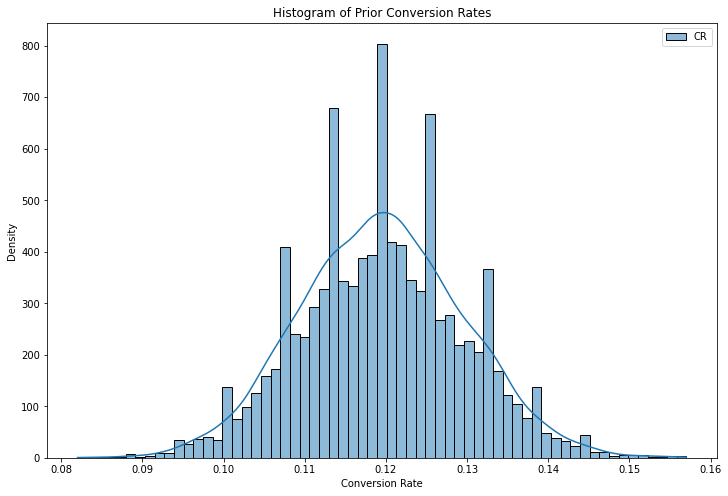

In [17]:
prior_means = [prior_data.sample(1000)['converted'].mean() for i in range (10000)]

_, ax = plt.subplots()
sns.histplot(prior_means, kde=True, label='CR')

ax.legend()
ax.set_xlabel('Conversion Rate')
ax.set_ylabel('Density')
ax.set_title('Histogram of Prior Conversion Rates')

Plot multiple priors with different strengths

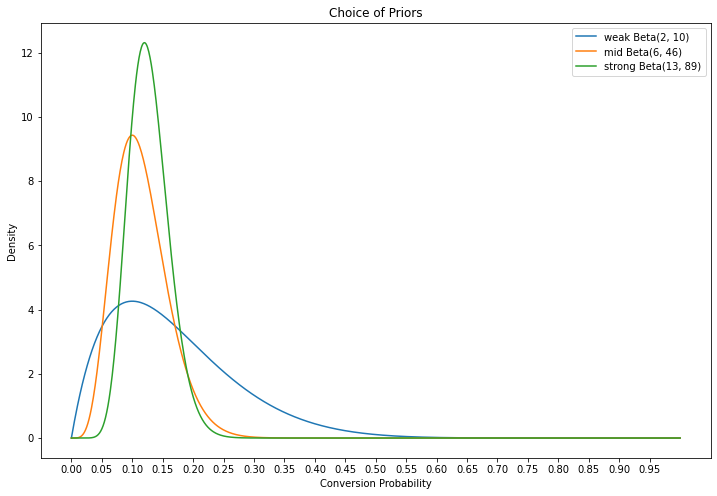

In [18]:
_, ax = plt.subplots(1, 1)
x = np.linspace(0,1,1000)

#equal distribution - non prior information beta(alpha=1, beta=1)

beta_weak = beta(round(conversion_rate, 1)*10 + 1, 10 + 1 - round(conversion_rate, 1)*10)
beta_mid = beta(round(conversion_rate, 1)*50 + 1, 50 + 1 - round(conversion_rate, 1)*50)
beta_strong = beta(round(conversion_rate, 2)*100 + 1, 100 + 1 - round(conversion_rate, 2)*100)

ax.plot(x, beta_weak.pdf(x), label=f'weak Beta({int(round(conversion_rate, 1)*10) + 1}, {10 + 1 - int(round(conversion_rate, 1)*10)})')
ax.plot(x, beta_mid.pdf(x), label=f'mid Beta({int(round(conversion_rate, 1)*50) + 1}, {50 + 1 - int(round(conversion_rate, 1)*50)})')
ax.plot(x, beta_strong.pdf(x), label=f'strong Beta({int(round(conversion_rate, 2)*100) + 1}, {100 + 1 - int(round(conversion_rate, 2)*100)})')

ax.set_xlabel('Conversion Probability')
ax.set_ylabel('Density')
ax.set_title('Choice of Priors')
ax.set_xticks(np.arange(0,1,0.05))
ax.legend()

Choose prior which is between weak and mid

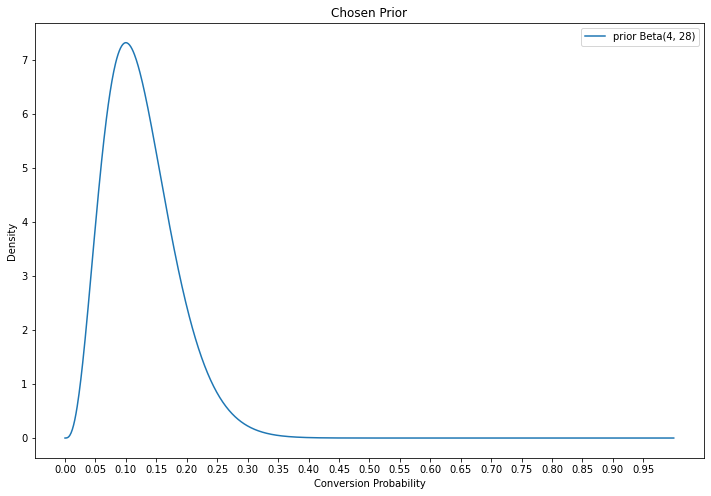

In [19]:
prior_alpha = round(conversion_rate, 1)*30 + 1
prior_beta = 30 + 1 - round(conversion_rate, 1)*30

prior = beta(prior_alpha, prior_beta)

fig, ax = plt.subplots(1, 1)
x = np.linspace(0,1,1000)

ax.plot(x, prior.pdf(x), label=f'prior Beta({int(round(conversion_rate, 1)*30) + 1}, {30 + 1 - int(round(conversion_rate, 1)*30)})')
ax.set_xlabel('Conversion Probability')
ax.set_ylabel('Density')
ax.set_title('Chosen Prior')
ax.set_xticks(np.arange(0,1,0.05))
ax.legend()

# 3.Experiment

In [20]:
experiment_data = data[(data['week_id'] <= 3)].copy()

In [21]:
experiment_data.head(5)

,user_id,timestamp,group,landing_page,converted,week_id
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,3
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,2
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,2
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,3


In [22]:
print(f'Exeriment data shape: {experiment_data.shape}')

Exeriment data shape: (273429, 6)


In [23]:
likelihood = binom.pmf(k= experiment_data['converted'].sum(), n=experiment_data['converted'].shape[0], p= prior_alpha/(prior_alpha+prior_beta))

In [24]:
prior_alpha/(prior_alpha+prior_beta)

0.125

In [25]:
likelihood

4.077523733431259e-20

In [29]:
# https://towardsdatascience.com/pdf-is-not-a-probability-5a4b8a5d9531
# https://towardsdatascience.com/bayesian-inference-intuition-and-example-148fd8fb95d6

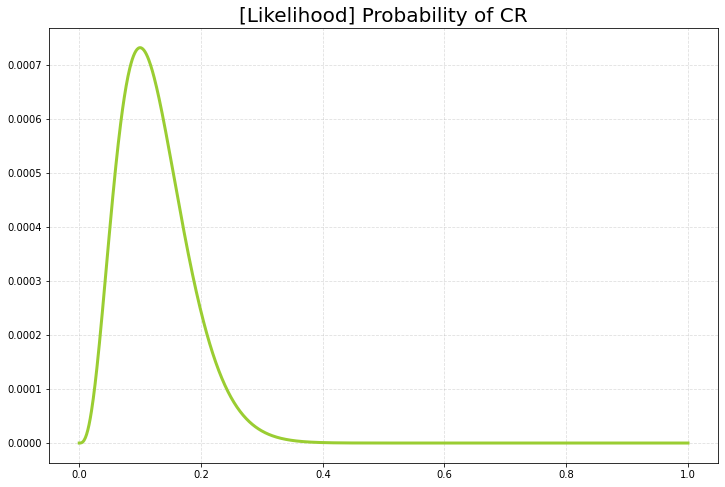

In [40]:
### Likelihood P(X|θ) for all θ's

theta = np.linspace(0,1,1000)

likelihood = binom.pmf(k= experiment_data['converted'].sample(1000).sum(), n=experiment_data['converted'].sample(1000).shape[0], p=theta)# Create the plot
prior = beta.cdf(x=theta + 0.0001, a=prior_alpha, b=prior_beta) - beta.cdf(x= theta, a=prior_alpha, b=prior_beta)

fig, ax = plt.subplots()
plt.plot(theta, prior, linewidth=3, color='yellowgreen')
plt.title('[Likelihood] Probability of CR' , fontsize=20)
# plt.xlabel(’Theta’, fontsize=16)
# plt.ylabel(’Probability’, fontsize=16)# Add a grid
plt.grid(alpha=.4, linestyle='--')# Show the plot
plt.show()

In [41]:
results = experiment_data.groupby('group').agg({'user_id': pd.Series.nunique, 'converted': sum})

results.rename({'user_id': 'sampleSize'}, axis=1, inplace=True)

results['conversionRate'] = results['converted']/results['sampleSize']

print(results)

           sampleSize  converted  conversionRate
group                                           
control        135723      16418        0.120967
treatment      135965      16251        0.119523


Verify the lift in CR between treamtent and control groups

In [42]:
lift = (results['conversionRate']['treatment'] - results['conversionRate']['control']) / results['conversionRate']['control']

print(lift)

-0.011933528105475752


Update the prior with data from control and treatment groups in order to achieve posterior

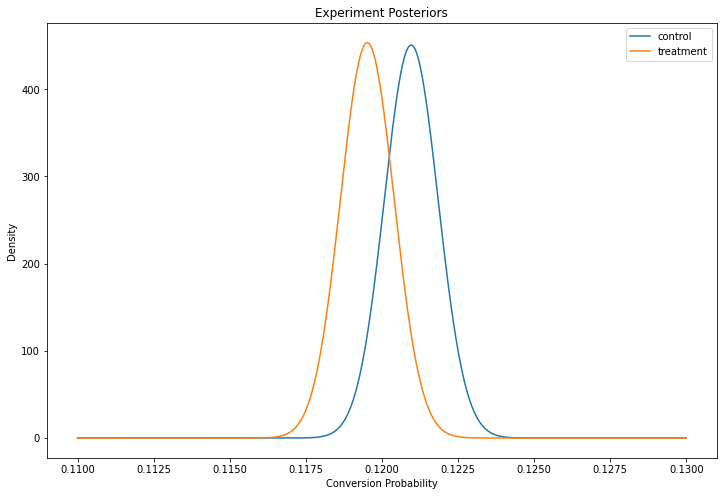

In [34]:
control = beta(prior_alpha + results.loc['control', 'converted'], prior_beta + results.loc['control', 'sampleSize'] - results.loc['control', 'converted'])

treatment = beta(prior_alpha + results.loc['treatment', 'converted'], prior_beta + results.loc['treatment', 'sampleSize'] - results.loc['treatment', 'converted'])

fig, ax = plt.subplots()

x = np.linspace(0.11,0.13,1000)

ax.plot(x, control.pdf(x), label='control')
ax.plot(x, treatment.pdf(x), label='treatment')
ax.set_xlabel('Conversion Probability')
ax.set_ylabel('Density')
ax.set_title('Experiment Posteriors')
ax.legend()

Take sample from posterior distributions of control and treatment and present results in format of probability that one group does avieches higher CR than other

In [35]:
## sample from Posteriors

control_samples = control.rvs(1000)
treatment_samples = treatment.rvs(1000)

probability = np.mean(treatment_samples > control_samples)

print('Probability that treatment > control: {}%'.format(probability*100))

Probability that treatment > control: 13.0%


In [36]:
probability

0.13